<a href="https://colab.research.google.com/github/meenalnimje/Page-rank-algorithm/blob/main/page_rank_algo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
# Website data: Domain Rating, Backlinks, Linking Websites, Dofollow Backlinks (%), Traffic (in millions per month)
websites = [
    {"name": "Google Play", "domain_rating": 96, "backlinks": 8_600_000_000, "linking_websites": 2_000_000, "dofollow_backlinks": 89, "traffic": 589.2},
    {"name": "Shopify", "domain_rating": 93, "backlinks": 10_000_000, "linking_websites": 450_000, "dofollow_backlinks": 85, "traffic": 15.7},
    {"name": "Amazon", "domain_rating": 92, "backlinks": 72_000_000, "linking_websites": 110_000, "dofollow_backlinks": 72, "traffic": 457.3},
    {"name": "Walmart", "domain_rating": 88, "backlinks": 5_000_000, "linking_websites": 70_000, "dofollow_backlinks": 80, "traffic": 64.9},
    {"name": "Flipkart", "domain_rating": 89, "backlinks": 10_000_000, "linking_websites": 36_000, "dofollow_backlinks": 77, "traffic": 103.2},
    {"name": "Rakuten", "domain_rating": 91, "backlinks": 150_000_000, "linking_websites": 30_000, "dofollow_backlinks": 85, "traffic": 118.1},
    {"name": "eBay", "domain_rating": 92, "backlinks": 522_000_000, "linking_websites": 312_000, "dofollow_backlinks": 81, "traffic": 74.9},
    {"name": "Nike", "domain_rating": 93, "backlinks": 30_000_000, "linking_websites": 200_000, "dofollow_backlinks": 88, "traffic": 69.2},
    {"name": "AliExpress", "domain_rating": 92, "backlinks": 92_000_000, "linking_websites": 149_000, "dofollow_backlinks": 84, "traffic": 43.7},
    {"name": "Justdial", "domain_rating": 83, "backlinks": 1_800_000, "linking_websites": 13_000, "dofollow_backlinks": 91, "traffic": 47.9},
    {"name": "Myntra", "domain_rating": 85, "backlinks": 3_000_000, "linking_websites": 50_000, "dofollow_backlinks": 76, "traffic": 17.1},
    {"name": "Nykaa", "domain_rating": 86, "backlinks": 10_000_000, "linking_websites": 60_000, "dofollow_backlinks": 78, "traffic": 3.5},
    {"name": "Shein", "domain_rating": 85, "backlinks": 120_000_000, "linking_websites": 300_000, "dofollow_backlinks": 82, "traffic": 32.2},
    {"name": "Adidas", "domain_rating": 87, "backlinks": 35_000_000, "linking_websites": 56_000, "dofollow_backlinks": 99, "traffic": 12.6},
    {"name": "Ajio", "domain_rating": 74, "backlinks": 607_000, "linking_websites": 9_500, "dofollow_backlinks": 95, "traffic": 4.8},
    {"name": "Meesho", "domain_rating": 76, "backlinks": 666_000, "linking_websites": 10_000, "dofollow_backlinks": 87, "traffic": 11.8},
    {"name": "Croma", "domain_rating": 72, "backlinks": 63_000, "linking_websites": 6_700, "dofollow_backlinks": 77, "traffic": 5.5},
    {"name": "OLX", "domain_rating": 85, "backlinks": 25_000_000, "linking_websites": 150_000, "dofollow_backlinks": 80, "traffic": 9.4}
]
features = pd.DataFrame({
    'backlinks': [website['backlinks'] for website in websites],
    'linking_websites': [website['linking_websites'] for website in websites],
    'dofollow_backlinks': [website['dofollow_backlinks'] for website in websites],
    'traffic': [website['traffic'] for website in websites]
})
target = np.array([website['domain_rating'] for website in websites])
# Log-transform large values and scale features
features['backlinks'] = np.log(features['backlinks'] + 1)
features['linking_websites'] = np.log(features['linking_websites'] + 1)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Train XGBoost Regressor
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3)
xgb_model.fit(scaled_features, target)

# Predict regression scores using XGBoost
regression_scores = xgb_model.predict(scaled_features)

# Normalize regression scores for weighting
normalized_regression_scores = regression_scores / regression_scores.sum()

# Normalize traffic with a logarithmic scale
log_traffic = np.log(features['traffic'] + 1)
normalized_traffic = log_traffic / log_traffic.sum()

# Combine regression scores and traffic
external_factors = 0.5 * normalized_regression_scores + 0.5 * normalized_traffic  # Adjust weights as needed

# Initialize PageRank
n = len(websites)
pagerank = np.array([website['domain_rating'] for website in websites], dtype=float)
link_matrix = np.ones((n, n)) - np.eye(n)  # Full connectivity excluding self-links

# PageRank computation with traffic emphasis
iterations = 100
damping_factor = 0.85

def calculate_pagerank_with_traffic_emphasis():
    global pagerank
    for _ in range(iterations):
        new_pagerank = np.zeros(n)
        for j in range(n):
            incoming_links = link_matrix[:, j]
            sum_contrib = 0
            for k in range(n):
                if incoming_links[k] == 1:
                    link_contrib = pagerank[k] / np.sum(link_matrix[k])
                    sum_contrib += link_contrib

            # Use the external factor (regression + traffic)
            external_factor = external_factors[j]
            new_pagerank[j] = (1 - damping_factor) * external_factor + damping_factor * sum_contrib

        if np.allclose(pagerank, new_pagerank, atol=1e-6):
            break
        pagerank = new_pagerank

calculate_pagerank_with_traffic_emphasis()

# Output results
pagerank_df = pd.DataFrame({
    'Website': [website['name'] for website in websites],
    'Domain Rating': [website['domain_rating'] for website in websites],
    'Traffic': [website['traffic'] for website in websites],
    'PageRank': pagerank
}).sort_values(by='PageRank', ascending=False)

print(pagerank_df)

        Website  Domain Rating  Traffic  PageRank
0   Google Play             96    589.2  0.059117
2        Amazon             92    457.3  0.058655
5       Rakuten             91    118.1  0.057112
4      Flipkart             89    103.2  0.056873
6          eBay             92     74.9  0.056656
7          Nike             93     69.2  0.056614
3       Walmart             88     64.9  0.056317
8    AliExpress             92     43.7  0.056067
9      Justdial             83     47.9  0.055756
12        Shein             85     32.2  0.055419
1       Shopify             93     15.7  0.055019
10       Myntra             85     17.1  0.054742
13       Adidas             87     12.6  0.054515
17          OLX             85      9.4  0.054129
15       Meesho             76     11.8  0.053946
11        Nykaa             86      3.5  0.053238
16        Croma             72      5.5  0.053012
14         Ajio             74      4.8  0.052973


In [11]:
import pandas as pd
from scipy.stats import spearmanr, kendalltau

# Actual rankings
actual_ranking = {
    "play.google.com": 1, "amazon.com": 2, "amazon.in": 3, "flipkart.com": 4, "rakuten.co.jp": 5,
    "amazon.de": 6, "amazon.co.jp": 7, "etsy.com": 8, "amazon.co.uk": 9, "mercadolivre.com.br": 10,
    "trendyol.com": 11, "tokopedia.com": 12, "ebay.com": 13, "allegro.pl": 14, "sahibinden.com": 15,
    "nike.com": 16, "walmart.com": 17, "shopee.co.id": 18, "amazon.fr": 19, "amazon.it": 20,
    "mercadolibre.com.mx": 21, "justdial.com": 22, "mercadolibre.com.ar": 23, "amazon.es": 24,
    "target.com": 25, "aliexpress.com": 26, "zara.com": 27, "blibli.com": 28, "hepsiburada.com": 29,
    "olx.pl": 30, "hm.com": 31, "shein.com": 32, "amazon.com.br": 33, "my-best.com": 34,
    "akakce.com": 35, "amazon.ca": 36, "thegioididong.com": 37, "leboncoin.fr": 38, "lazada.co.id": 39,
    "magazineluiza.com.br": 40, "ozon.ru": 41, "amazon.com.mx": 42, "craigslist.org": 43, "skroutz.gr": 44,
    "kakaku.com": 45, "olx.ua": 46, "shopee.com.br": 47, "shopee.co.th": 48, "shopee.vn": 49,
    "olx.com.br": 50, "myntra.com": 51, "kleinanzeigen.de": 52, "bestbuy.com": 53, "americanas.com.br": 54,
    "ebay.co.uk": 55, "rozetka.com.ua": 56, "emag.ro": 57, "mercadolibre.com.co": 58, "nordstrom.com": 59,
    "costco.com": 60, "mercari.com": 61, "marksandspencer.com": 62, "shopify.com": 63, "argos.co.uk": 64,
    "dienmayxanh.com": 65, "olx.ro": 66, "shopee.tw": 67, "falabella.com": 68, "elcorteingles.es": 69,
    "bachhoaxanh.com": 70, "macys.com": 71, "mercadolibre.cl": 72, "bol.com": 73, "pandora.net": 74,
    "cimri.com": 75, "zalando.de": 76, "meesho.com": 77, "amazon.com.tr": 78, "fptshop.com.vn": 79,
    "next.co.uk": 80, "subito.it": 81, "ebay.de": 82, "cdiscount.com": 83, "lazada.co.th": 84,
    "adidas.com": 85, "dior.com": 86, "idealo.de": 87, "casasbahia.com.br": 88, "amazon.com.au": 89,
    "spirithalloween.com": 90, "alibaba.com": 91, "otto.de": 92, "max.com": 93, "temu.com": 94,
    "asos.com": 95, "stockx.com": 96
}

model_ranking = [
    ("Google Play", 1), ("Amazon", 2), ("Rakuten", 3), ("Flipkart", 4), ("eBay", 5),
    ("Nike", 6), ("Walmart", 7), ("AliExpress", 8), ("Justdial", 9), ("Shein", 10),
    ("Shopify", 11), ("Myntra", 12), ("Adidas", 13), ("OLX", 14), ("Meesho", 15),
    ("Nykaa", 16), ("Croma", 17), ("Ajio", 18)
]

# Map model rankings to actual website URLs
url_map = {
    "Google Play": "play.google.com", "Amazon": "amazon.com", "Rakuten": "rakuten.co.jp",
    "Flipkart": "flipkart.com", "eBay": "ebay.com", "Nike": "nike.com", "Walmart": "walmart.com",
    "AliExpress": "aliexpress.com", "Justdial": "justdial.com", "Shein": "shein.com",
    "Shopify": "shopify.com", "Myntra": "myntra.com", "Adidas": "adidas.com", "OLX": "olx.pl",
    "Meesho": "meesho.com", "Nykaa": "nykaa.com", "Croma": "croma.com", "Ajio": "ajio.com"
}

# Assign a default rank for missing websites
max_actual_rank = max(actual_ranking.values())
default_rank = max_actual_rank + 1

actual_ranks = []
predicted_ranks = []

for name, model_rank in model_ranking:
    url = url_map.get(name)
    if url in actual_ranking:
        actual_ranks.append(actual_ranking[url])
    else:
        actual_ranks.append(default_rank)  # Assign default rank
    predicted_ranks.append(model_rank)

# Calculate Spearman's ρ and Kendall's τ
spearman_corr, _ = spearmanr(actual_ranks, predicted_ranks)
kendall_corr, _ = kendalltau(actual_ranks, predicted_ranks)

# Print results
print(f"Spearman's Rank Correlation Coefficient: {spearman_corr:.4f}")
print(f"Kendall's Tau: {kendall_corr:.4f}")


Spearman's Rank Correlation Coefficient: 0.9669
Kendall's Tau: 0.8845


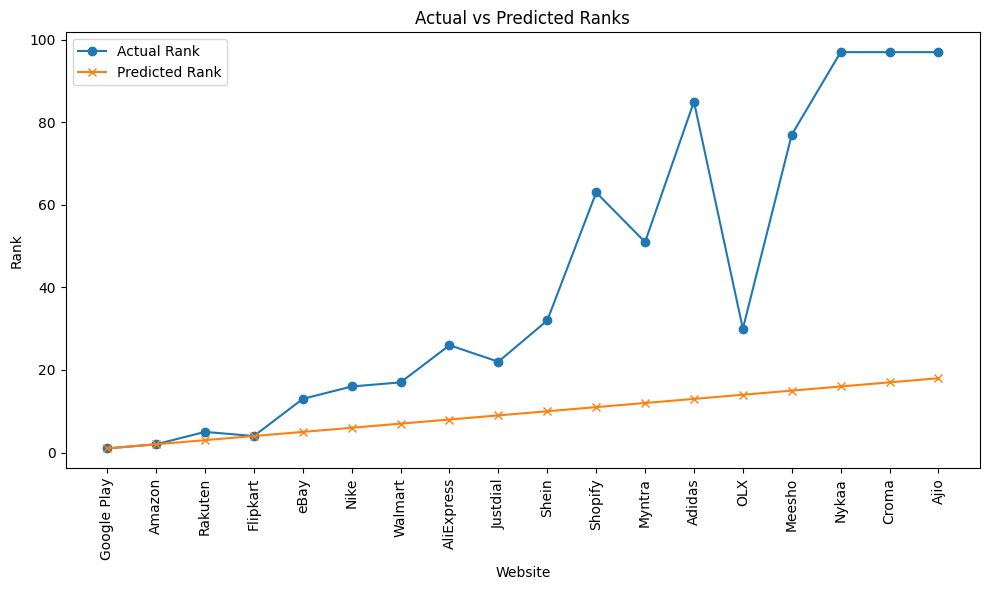

In [13]:
import matplotlib.pyplot as plt

# Create a DataFrame for plotting
df = pd.DataFrame({
    'Website': list(url_map.keys()),
    'Actual Rank': actual_ranks,
    'Predicted Rank': predicted_ranks
})

# Plot actual vs predicted ranks
plt.figure(figsize=(10, 6))
plt.plot(df['Website'], df['Actual Rank'], label='Actual Rank', marker='o')
plt.plot(df['Website'], df['Predicted Rank'], label='Predicted Rank', marker='x')
plt.xticks(rotation=90)
plt.xlabel('Website')
plt.ylabel('Rank')
plt.title('Actual vs Predicted Ranks')
plt.legend()
plt.tight_layout()
plt.show()
